<a href="https://colab.research.google.com/github/anujbhandari2/ECS171-Final-Project/blob/main/ECS_171_Final_Project_Open_Source_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bitcoin Price Prediction with Neural prophet

## This notebook demonstrates an end-to-end pipeline for forecasting **daily Bitcoin price**

# Features / Steps:
## 1. **Load and explore** dataset (Date, Open, High, Low, Close, Volume).
## 2. **Data cleaning** and optional **feature engineering** (technical indicators).
## 3. **Scaling** for better neural network training.
## 4. **Windowing** (past N days) and **horizon setting** (predict next 1 day).
##    - Easily extendable to multi-step forecasting (e.g., next 7 days).
## 5. Model Development: The Neural Prophet model is trained on the input data. We used a small trend regularization term (0.1) so that the model was able to capture detailed price fluctuations. This is valued over a generally smooth prediction because of the volatile nature of Bitcoin. We also used 1 as the number of lag terms, as this allowed the model to pick up on large up and down movements in the prices.

## 6. **Testing & evaluation** using MSE, MAE, RMSE, and MAPE.
## 7. **Plotting** predictions vs. actual prices.

\- Global Import Statements -

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.functional import mse_loss
from sklearn.preprocessing import MinMaxScaler
import os
import kagglehub
from neuralprophet import NeuralProphet, set_log_level
import torch

In [ ]:
# disable logging unless it's an error
set_log_level("ERROR")

# 1. Loading the dataset from Kaggle

In [ ]:
path = kagglehub.dataset_download("arslanr369/bitcoin-price-2014-2023")
print("Path to dataset files:", path)

# List files in the directory
files = os.listdir(path)
print("Files in dataset directory:", files)

# Identify the CSV file
csv_file = [f for f in files if f.endswith(".csv")][0]
csv_path = os.path.join(path, csv_file)

# Load dataset
df = pd.read_csv(csv_path, parse_dates=['Date'])
# sanity checks #
df.sort_values(by='Date', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.head())
print(df.tail())
print(df.info())
print(df.describe())

# set seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

Path to dataset files: /Users/stanleyko/.cache/kagglehub/datasets/arslanr369/bitcoin-price-2014-2023/versions/1
Files in dataset directory: ['BTC-USD.csv']
        Date        Open        High         Low       Close   Adj Close  \
0 2014-09-17  465.864014  468.174011  452.421997  457.334015  457.334015   
1 2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2 2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
3 2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
4 2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   

     Volume  
0  21056800  
1  34483200  
2  37919700  
3  36863600  
4  26580100  
           Date          Open          High           Low         Close  \
3223 2023-07-15  30331.783203  30407.781250  30263.462891  30295.806641   
3224 2023-07-16  30297.472656  30437.560547  30089.669922  30249.132813   
3225 2023-07-17  30249.626953  30336.400391  29685.783203  30145.888672   
322

# 2. Basic Data Cleaning & Feature Selection
## - Besides using just **Close** price, we can leverage:
##   - **Technical indicators** like RSI, moving averages, etc.
##   - **Volume** can be a valuable feature.
##   - **High, Low, Open** to capture intraday volatility.
##   
## - The final model input dimension becomes greater than 1 if we include these features.


In [ ]:
# Example: Creating a 7-day Simple Moving Average (SMA)
df['SMA_7'] = df['Close'].rolling(window=7).mean()

# Example: 14-day EMA
df['EMA_14'] = df['Close'].ewm(span=14, adjust=False).mean()

# Example: RSI (14 days)
def compute_rsi(series, window=14):
    delta = series.diff()
    gain = (delta.where(delta > 0, 0.0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0.0)).rolling(window=window).mean()
    rs = gain / (loss + 1e-8)
    return 100.0 - (100.0 / (1.0 + rs))

df['RSI_14'] = compute_rsi(df['Close'], 14)

# We'll fill initial NAs caused by rolling with the next valid (or just drop them).
df.fillna(method='bfill', inplace=True)

# Let's keep the following features
# 1) Close price
# 2) Volume
# 3) SMA_7
# 4) EMA_14
# 5) RSI_14
feature_cols = ['Date', 'Close', 'Volume', 'SMA_7', 'EMA_14', 'RSI_14']

df_features = df[feature_cols].copy()

# renaming to match with NeuralProphet's requirements
df_features.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
df_features.head()

WARNING - (py.warnings._showwarnmsg) - /var/folders/sx/fxh2dp3x4ysfd39194pck6f80000gn/T/ipykernel_50233/3991748474.py:18: FutureWarning:

DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.




,ds,y,Volume,SMA_7,EMA_14,RSI_14
0,2014-09-17,457.334015,21056800,417.462572,457.334015,31.997433
1,2014-09-18,424.440002,34483200,417.462572,452.948147,31.997433
2,2014-09-19,394.795990,37919700,417.462572,445.194526,31.997433
3,2014-09-20,408.903992,36863600,417.462572,440.355788,31.997433
4,2014-09-21,398.821014,26580100,417.462572,434.817818,31.997433


# 3. Train-Val-Test Split
## We'll do:
## - **Train**: 2014 to ~2020 (first 80% of data)
## - **Validation**: next 10% of data
## - **Test**: final 10%


In [ ]:
# Determine number of samples in dataset
n_samples = len(df_features)

# split dataset into training, val, and test
train_size = int(n_samples * 0.8)
val_size = int(n_samples * 0.1)
test_size = n_samples - train_size - val_size

# Create train, validation, and test datasets
train_df = df_features.iloc[:train_size]
val_df   = df_features.iloc[train_size:train_size+val_size]
test_df  = df_features.iloc[train_size+val_size:]

print("Train set:", train_df.shape)
print("Val set:  ", val_df.shape)
print("Test set: ", test_df.shape)

Train set: (2582, 6)
Val set:   (322, 6)
Test set:  (324, 6)


# 4. Scaling the data
## We'll use 'MinMaxScaler' to scale the 'Close' prices to (0, 1) range for easier neural network training

In [ ]:
# columns that we want to scale
non_date_cols = ['y', 'Volume', 'SMA_7', 'EMA_14', 'RSI_14']

# initialze minmaxscaler and fit to training data
scaler = MinMaxScaler()
scaler.fit(train_df[non_date_cols])

# transform train, validation, and test sets using the fitted scaler

train_scaled = scaler.transform(train_df[non_date_cols])
val_scaled   = scaler.transform(val_df[non_date_cols])
test_scaled  = scaler.transform(test_df[non_date_cols])

# Convert back to DataFrame for clarity
train_scaled_df = pd.DataFrame(train_scaled,
                               columns=non_date_cols,
                               index=train_df.index)
val_scaled_df   = pd.DataFrame(val_scaled,
                               columns=non_date_cols,
                               index=val_df.index)
test_scaled_df  = pd.DataFrame(test_scaled,
                               columns=non_date_cols,
                               index=test_df.index)

# Check range
print("Min of train data after scaling:", train_scaled_df.min())
print("Max of train data after scaling:", train_scaled_df.max())

# Add the 'ds' column back to the scaled dataframes
train_scaled_df['ds'] = train_df['ds']
val_scaled_df['ds'] = val_df['ds']
test_scaled_df['ds'] = test_df['ds']

display(train_scaled_df.head())

Min of train data after scaling: y         0.0
Volume    0.0
SMA_7     0.0
EMA_14    0.0
RSI_14    0.0
dtype: float64
Max of train data after scaling: y         1.0
Volume    1.0
SMA_7     1.0
EMA_14    1.0
RSI_14    1.0
dtype: float64


,y,Volume,SMA_7,EMA_14,RSI_14,ds
0,0.004409,0.000043,0.003459,0.003857,0.287147,2014-09-17
1,0.003890,0.000081,0.003459,0.003784,0.287147,2014-09-18
2,0.003422,0.000091,0.003459,0.003655,0.287147,2014-09-19
3,0.003645,0.000088,0.003459,0.003574,0.287147,2014-09-20
4,0.003485,0.000059,0.003459,0.003482,0.287147,2014-09-21


# 5. Defining the Neural Prophet Model

# **Hyperparameters**:
## - `trend_reg=0.1`: Smaller trend allows for the model to capture more detailed trend variations, which is important for day to day bitcoin price changes.
## - `learning_rate=0.01`
## - `batch_size=16`
## - `epochs=60`
## - `n_lags=10`: Allows the model to look at data 10 time steps behind, having more data to base the current day's prediction on.

# **Oher Notes**:
## - Using `add_future_regressor` to have the model base it's prediction on both the date and the other attributes


In [ ]:
m = NeuralProphet(
    trend_reg=0.1,
    learning_rate=0.01,
    batch_size=16,
    epochs=60,
    n_lags=1,
)

m.add_future_regressor('Volume')
m.add_future_regressor('SMA_7')
m.add_future_regressor('EMA_14')
m.add_future_regressor('RSI_14')

metrics = m.fit(train_scaled_df, validation_df=val_scaled_df)
display(metrics)

WARNING - (py.warnings._showwarnmsg) - /Users/stanleyko/git/coursework/ecs171/venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Users/stanleyko/git/coursework/ecs171/venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning:

MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.




Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

,MAE_val,RMSE_val,Loss_val,RegLoss_val,epoch,MAE,RMSE,Loss,RegLoss
0,1.102155,1.288470,1.352599,0.0,0,0.992982,1.200467,0.933041,0.0
1,0.740203,0.900593,0.865056,0.0,1,0.586381,0.740211,0.524942,0.0
2,0.451800,0.558272,0.476085,0.0,2,0.291421,0.386605,0.229685,0.0
3,0.226459,0.267308,0.183194,0.0,3,0.135808,0.189629,0.081709,0.0
4,0.112902,0.134657,0.055036,0.0,4,0.070297,0.093401,0.024636,0.0
5,0.045878,0.059725,0.010988,0.0,5,0.036994,0.049629,0.006735,0.0
6,0.036350,0.049236,0.007467,0.0,6,0.028047,0.037186,0.003627,0.0
7,0.041583,0.053223,0.008726,0.0,7,0.025600,0.033996,0.003000,0.0
8,0.032978,0.043297,0.005775,0.0,8,0.025665,0.033149,0.002910,0.0
9,0.034599,0.045549,0.006391,0.0,9,0.025352,0.032403,0.002775,0.0


# 6. Evaluation on Test
## - **MSE**  
## - **MAE**  
## - **RMSE**  
## - **MAPE**  

In [ ]:
predictions = m.predict(test_scaled_df)
# display(predictions.tail())

# Remove NaN values from predictions and test data
# valid_indices = ~np.isnan(predictions['yhat1'].values)
# valid_predictions = predictions['yhat1'].values[valid_indices]
# valid_test_scaled = test_scaled_df['y'].values[valid_indices]

# print(valid_predictions)

# Inverse transform the predictions
def inverse_transform_close(scaled_close):
    """
    scaled_close: shape (N,)
    Returns: real BTC prices
    """
    # We create a 2D array of zeros with the same number of columns as we had in training
    # Fill the first column with scaled_close, then invert transform
    dummy = np.zeros((len(scaled_close), len(non_date_cols)))
    dummy[:, 0] = scaled_close  # place it in 'Close' position
    dummy_inverted = scaler.inverse_transform(dummy)
    return dummy_inverted[:, 0]  # return only 'Close' column

inverse_preds = inverse_transform_close(predictions['yhat1'].values)
inverse_test = inverse_transform_close(test_scaled_df['y'].values)

# first value is nan because of n_lags
inverse_preds[0] = inverse_preds[1]
# print(inverse_preds)

# Evaluations
mse = np.mean((inverse_preds - inverse_test)**2)
rmse = math.sqrt(mse)
mae = np.mean(np.abs(inverse_preds - inverse_test))
mape = np.mean(np.abs((inverse_preds - inverse_test) / (inverse_test+1e-8))) * 100

print("Test MSE (real scale):  ", mse)
print("Test RMSE (real scale): ", rmse)
print("Test MAE (real scale):  ", mae)
print("Test MAPE (real scale): ", mape)

# print("Test MSE (real scale):  ", mse)
# print("Test RMSE (real scale): ", rmse)
# print("Test MAE (real scale):  ", mae)
# print("Test MAPE (real scale): ", mape)

WARNING - (py.warnings._showwarnmsg) - /Users/stanleyko/git/coursework/ecs171/venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Users/stanleyko/git/coursework/ecs171/venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Users/stanleyko/git/coursework/ecs171/venv/lib/python3.12/site-packages/neuralprophet/df_utils.py:1152: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.


WARNING - (py.warnings._showwarnmsg) - /Users/stanleyko/git/coursework/ecs171/venv/lib/python3.12/site-packages/neuralprophet/data/split.py:69: FutureW

Predicting: 162it [00:00, ?it/s]

Test MSE (real scale):   279113.1335554787
Test RMSE (real scale):  528.3115875650266
Test MAE (real scale):   403.96513750180605
Test MAPE (real scale):  1.7767301175343162


# 7. Visualization of predictions on test

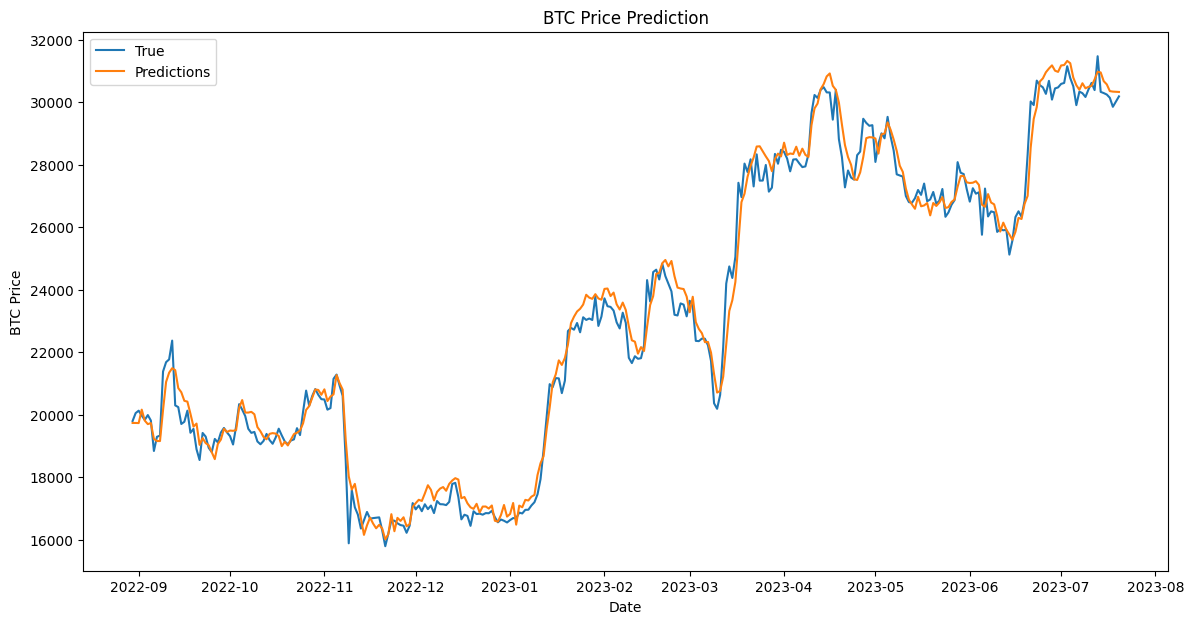

In [ ]:
# Plot the predictions
plt.figure(figsize=(14, 7))
plt.plot(test_df['ds'], inverse_test, label='True')
plt.plot(test_df['ds'], inverse_preds, label='Predictions')
plt.title("BTC Price Prediction")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend()
plt.show()